In [36]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import time

In [2]:
#setting the small and large datasets
sfile='small_37.txt'
lfile='large_18.txt'

In [3]:
#function to load the data
def load_data(filename):
    data, labels = [], []
    
    with open(filename) as f:
        lines = f.readlines()
    
    for item in lines:
        temp=item.split()
        temp=np.float_(temp)
        labels.append(temp[0])
        temp=np.delete(temp,0)
        data.append(temp)
    
    data=np.array(data)
    labels=np.array(labels)
    return data,labels

In [4]:
#function to calculate euclidean distance
def euclid(row1,row2,tup):
    dist=0
    for j in tup:
        dist+=(row1[j-1]-row2[j-1])**2
    dist=sqrt(dist)
    return dist

In [5]:
#function to check if the current feature is in the visited features list
def check_if_already_visited(features, testfeature):
    if len(features)==0:
        return 0
    if testfeature in features:
            return 1
    return 0

In [6]:
#function for leave one out cross validation when using backward elimination
def cross_valid_backward(data,labels,features,testfeature):
    #creating a copy of the feature list
    tempo=features.copy()
    #for the case when all features have to be considered    
    if testfeature==-1:
        pass
    #removing the feature being tested from the list of features
    else:
        tempo.remove(testfeature)
    
    ctr=0
    
    #finding the nearest neighbor with the least euclidean distance
    for i in range(len(data)):
        nearest_neighbor = np.inf
        nearest_neighbor_index=0
        for j in range(len(data)):
            dist=euclid(data[i],data[j],tempo)
            if(nearest_neighbor > dist and j != i):
                nearest_neighbor=dist
                nearest_neighbor_index = j
        
        #incrementing the counter if the predicted label(using the nearest neighbor) matches the actual label
        if(labels[i]==labels[nearest_neighbor_index]):
            ctr+=1
    
    #returning the accuracy
    return ctr/len(data)

In [7]:
#function to perform backward elimination for feature selection
def backward_feature_selection(data,labels):
    #initializing the feature list ot contain all the features 
    cur_features=list(range(1,len(data[0])+1))
    highestaccu=0
    res_features=[]
    accu_list=[]
    depth=0
    
    #calculating the accuracy with all the features
    accu=cross_valid_backward(data,labels,cur_features,-1)
    print("At tree depth {0}".format(depth))
    print("With all the features i.e. ({0}) accuracy is {1}".format(cur_features,round(accu*100,2)))
    accu_list.append(round(accu*100,2))
    
    #feature elimination loop
    for i in range(len(data[0])):
        testfeature=-1
        bestaccu=0
        depth+=1
        
        #if only one feature is present in the list of features being considered then stop
        if(len(cur_features)==1):
            break
        
        
        print("\n\nAt tree depth {0}".format(depth))
        
        for j in range(len(data[i]-1)):
            if (check_if_already_visited(cur_features,j)==1):
                
                accu=cross_valid_backward(data,labels,cur_features,j)
                tempo=cur_features.copy()
                tempo.remove(j)
                print("Considering removing feature ({0}) \nAnd testing with features: ({1}) the accuracy obtained is {2}%".format(j,tempo,round(accu*100,2)))
                
                #Updating the best accuracy to know which feature to eliminate
                if(accu>bestaccu):
                    bestaccu=accu
                    testfeature=j
                    
        #Removing the feature that gives the best accuracy
        if(testfeature!=-1):
            cur_features.remove(testfeature)
            print("\nRemoving feature ({0})\nConsidering the feature(s) ({1})\nGave the best accuracy of {2}%".format(testfeature,cur_features,round(bestaccu*100,2)))
        accu_list.append(round(bestaccu*100,2))
        
        #Updating the result of the highest accuracy obtained
        if(bestaccu>highestaccu):
            highestaccu=bestaccu
            res_features=[features for features in cur_features]
        else:
            print("\nModel did not improve on this level continuing search")
    
    #Displaying the features and the best accuracy obtained
    print("\nBest features after running the search: ({0})\nGave us an accuracy of {1}%".format(res_features,round(highestaccu*100,2)))
    
    return accu_list

In [8]:
#function for leave one out cross validation when using forward selection
def cross_valid_forward(data,labels,features,testfeature):
    
    #Adding the current feature being tested to the list of features
    temp=features+[testfeature]
    ctr=0
    
    #finding the nearest neighbor
    for i in range(len(data)):
        nearest_neighbor = np.inf
        nearest_neighbor_index=0
        for j in range(len(data)):
            dist=euclid(data[i],data[j],temp)
            if(nearest_neighbor > dist and j != i):
                nearest_neighbor=dist
                nearest_neighbor_index = j
        
        #incrementing the counter if the predicted label(using the nearest neighbor) matches the actual label
        if(labels[i]==labels[nearest_neighbor_index]):
            ctr+=1
            
    #returning the accuracy
    return ctr/len(data)

In [9]:
#function to perform forward feature selection
def forward_feature_selection(data,labels):
    cur_features=[]
    highestaccu=0
    res_features=[]
    accu_list=[]
    depth=0
    
    #forward feature selection loop
    for i in range(len(data[0])):
        #initialization
        testfeature=-1
        bestaccu=0
        depth+=1
        
        print("\n\nAt tree depth {0}".format(depth))
        
        for j in range(len(data[i])):
            
            #checking whether the feature is not already in the feature list
            if (check_if_already_visited(cur_features,j)==0):
                
                #calculating the accuracy
                accu=cross_valid_forward(data,labels,cur_features,j)
                
                #for single features
                if not cur_features:
                    print("Considering adding feature(s) ({0}) \nGave an accuracy of {1}%".format(j,round(accu*100,2)))
                
                #when considering multiple features
                else:
                    print("Considering adding feature ({0})\nAnd testing using existing feature(s) ({1}) \nGave an accuracy of {2}%".format(j,cur_features,round(accu*100,2)))
                
                #updating the best accuracy and deciding which feature to add
                if(accu>bestaccu):
                    bestaccu=accu
                    testfeature=j
                    
        #Updating the result for the highest accuracy obtained
        if(bestaccu>highestaccu):
            highestaccu=bestaccu
            res_features.append(testfeature)
        else:
            print("\nModel did not improve on this level continuing search")
        
        #adding the best feature to the list of features
        if(testfeature!=-1):
            cur_features.append(testfeature)
            print("\nAdding feature ({0})\nConsidering the feature(s): ({1})\nGave best accuracy of {2}%".format(testfeature,cur_features,round(bestaccu*100,2)))
        
        accu_list.append(round(bestaccu*100,2))
    
    #Displaying the features and the best accuracy obtained
    print("\nBest features after running the search: ({0}) \nGave an accuracy of {1}%".format(res_features,round(highestaccu*100,2)))
    
    return accu_list

In [10]:
#Loading the smaller dataset
data,labels = load_data(sfile)
print(data.shape)

(300, 10)


In [11]:
best_accu=forward_feature_selection(data,labels)



At tree depth 1
Considering adding feature(s) (0) 
Gave an accuracy of 65.33%
Considering adding feature(s) (1) 
Gave an accuracy of 72.0%
Considering adding feature(s) (2) 
Gave an accuracy of 68.67%
Considering adding feature(s) (3) 
Gave an accuracy of 67.0%
Considering adding feature(s) (4) 
Gave an accuracy of 65.67%
Considering adding feature(s) (5) 
Gave an accuracy of 67.33%
Considering adding feature(s) (6) 
Gave an accuracy of 65.67%
Considering adding feature(s) (7) 
Gave an accuracy of 67.67%
Considering adding feature(s) (8) 
Gave an accuracy of 86.0%
Considering adding feature(s) (9) 
Gave an accuracy of 62.67%

Adding feature (8)
Considering the feature(s): ([8])
Gave best accuracy of 86.0%


At tree depth 2
Considering adding feature (0)
And testing using existing feature(s) ([8]) 
Gave an accuracy of 83.0%
Considering adding feature (1)
And testing using existing feature(s) ([8]) 
Gave an accuracy of 82.33%
Considering adding feature (2)
And testing using existing fe

Text(0.5, 1.0, 'Forward feature selection for small dataset')

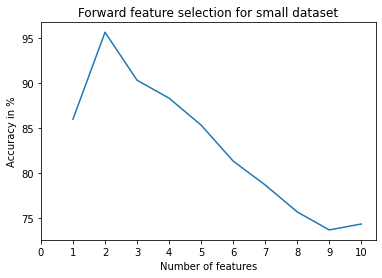

In [12]:
#plotting graph for forward selection
plt.plot(range(1,len(data[0])+1,1),best_accu)
plt.xlabel("Number of features")
x = np.arange(0, len(data[0])+1, 1)
plt.xticks(x)
plt.ylabel("Accuracy in %")
plt.title('Forward feature selection for small dataset')

In [13]:
best_accu=backward_feature_selection(data,labels)

At tree depth 0
With all the features i.e. ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) accuracy is 74.33


At tree depth 1
Considering removing feature (1) 
And testing with features: ([2, 3, 4, 5, 6, 7, 8, 9, 10]) the accuracy obtained is 73.0%
Considering removing feature (2) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10]) the accuracy obtained is 69.33%
Considering removing feature (3) 
And testing with features: ([1, 2, 4, 5, 6, 7, 8, 9, 10]) the accuracy obtained is 73.67%
Considering removing feature (4) 
And testing with features: ([1, 2, 3, 5, 6, 7, 8, 9, 10]) the accuracy obtained is 72.0%
Considering removing feature (5) 
And testing with features: ([1, 2, 3, 4, 6, 7, 8, 9, 10]) the accuracy obtained is 74.0%
Considering removing feature (6) 
And testing with features: ([1, 2, 3, 4, 5, 7, 8, 9, 10]) the accuracy obtained is 71.33%
Considering removing feature (7) 
And testing with features: ([1, 2, 3, 4, 5, 6, 8, 9, 10]) the accuracy obtained is 71.67%
Considering removing f

Text(0.5, 1.0, 'Backward elimination for small dataset')

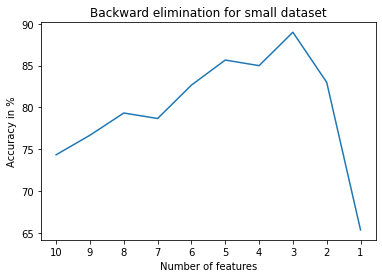

In [14]:
#plotting the graph for backward elimination
plt.plot(range(1,len(data[0])+1),best_accu)
plt.xlabel("Number of features")
x = np.arange(1, len(data[0])+1, 1)
plt.xticks(x,x[::-1])
plt.ylabel("Accuracy in %")
plt.title('Backward elimination for small dataset')

In [15]:
#loading the large dataset
data,labels=load_data(lfile)
print(data.shape)

(1000, 40)


In [16]:
best_accu = forward_feature_selection(data,labels)



At tree depth 1
Considering adding feature(s) (0) 
Gave an accuracy of 71.4%
Considering adding feature(s) (1) 
Gave an accuracy of 70.2%
Considering adding feature(s) (2) 
Gave an accuracy of 70.2%
Considering adding feature(s) (3) 
Gave an accuracy of 69.5%
Considering adding feature(s) (4) 
Gave an accuracy of 68.9%
Considering adding feature(s) (5) 
Gave an accuracy of 67.6%
Considering adding feature(s) (6) 
Gave an accuracy of 69.7%
Considering adding feature(s) (7) 
Gave an accuracy of 73.3%
Considering adding feature(s) (8) 
Gave an accuracy of 71.3%
Considering adding feature(s) (9) 
Gave an accuracy of 69.8%
Considering adding feature(s) (10) 
Gave an accuracy of 71.0%
Considering adding feature(s) (11) 
Gave an accuracy of 72.5%
Considering adding feature(s) (12) 
Gave an accuracy of 71.2%
Considering adding feature(s) (13) 
Gave an accuracy of 68.7%
Considering adding feature(s) (14) 
Gave an accuracy of 73.1%
Considering adding feature(s) (15) 
Gave an accuracy of 71.3%


Considering adding feature (14)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 93.8%
Considering adding feature (15)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 92.9%
Considering adding feature (16)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 92.2%
Considering adding feature (17)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 92.3%
Considering adding feature (20)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 93.7%
Considering adding feature (21)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 93.5%
Considering adding feature (22)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 93.2%
Considering adding feature (23)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 92.5%
Considering adding feature (24)
And testing using existing feature(s) ([18, 19]) 
Gave an accuracy of 92.1%
Considering adding feature (

Considering adding feature (10)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 88.0%
Considering adding feature (12)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 86.8%
Considering adding feature (13)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 86.6%
Considering adding feature (14)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 85.0%
Considering adding feature (15)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 87.2%
Considering adding feature (16)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 86.9%
Considering adding feature (20)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 87.6%
Considering adding feature (21)
And testing using existing feature(s) ([18, 19, 11, 17]) 
Gave an accuracy of 87.5%
Considering adding feature (22)
And testing using existing feature(s) ([

Considering adding feature (7)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 81.5%
Considering adding feature (8)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 81.7%
Considering adding feature (9)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 83.2%
Considering adding feature (10)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 83.8%
Considering adding feature (12)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 83.1%
Considering adding feature (13)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 83.3%
Considering adding feature (14)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 84.4%
Considering adding feature (15)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2]) 
Gave an accuracy of 84.1%
Considering adding 

Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 78.3%
Considering adding feature (4)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 78.9%
Considering adding feature (5)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 79.7%
Considering adding feature (6)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 79.2%
Considering adding feature (7)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 79.4%
Considering adding feature (8)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 81.9%
Considering adding feature (9)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39]) 
Gave an accuracy of 81.4%
Considering adding feature (10)
And testing using existing feature(s) ([18, 19, 11, 17, 29

Considering adding feature (0)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 78.7%
Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 75.8%
Considering adding feature (4)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 77.3%
Considering adding feature (5)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 77.8%
Considering adding feature (6)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 78.9%
Considering adding feature (7)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 77.2%
Considering adding feature (8)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20]) 
Gave an accuracy of 79.0%
Considering adding feature (9)
And testin

Considering adding feature (38)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31]) 
Gave an accuracy of 77.7%

Model did not improve on this level continuing search

Adding feature (33)
Considering the feature(s): ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33])
Gave best accuracy of 78.4%


At tree depth 13
Considering adding feature (0)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33]) 
Gave an accuracy of 75.2%
Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33]) 
Gave an accuracy of 75.0%
Considering adding feature (4)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33]) 
Gave an accuracy of 75.0%
Considering adding feature (5)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33]) 
Gave an accuracy of 76.7%
Considering adding feature (6)
And testing using existing feature(s) ([18, 19,

Considering adding feature (35)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38]) 
Gave an accuracy of 75.9%
Considering adding feature (36)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38]) 
Gave an accuracy of 74.0%
Considering adding feature (37)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38]) 
Gave an accuracy of 75.6%

Model did not improve on this level continuing search

Adding feature (24)
Considering the feature(s): ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24])
Gave best accuracy of 77.8%


At tree depth 15
Considering adding feature (0)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24]) 
Gave an accuracy of 75.0%
Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24]) 
Gave an accuracy of 73.8%
Considering adding feature (4)
And t

Considering adding feature (35)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16]) 
Gave an accuracy of 73.8%
Considering adding feature (36)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16]) 
Gave an accuracy of 72.1%
Considering adding feature (37)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16]) 
Gave an accuracy of 73.7%

Model did not improve on this level continuing search

Adding feature (4)
Considering the feature(s): ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4])
Gave best accuracy of 76.7%


At tree depth 17
Considering adding feature (0)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4]) 
Gave an accuracy of 74.5%
Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4]) 
Gave an accuracy o

Considering adding feature (36)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15]) 
Gave an accuracy of 74.7%
Considering adding feature (37)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15]) 
Gave an accuracy of 74.9%

Model did not improve on this level continuing search

Adding feature (23)
Considering the feature(s): ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23])
Gave best accuracy of 76.7%


At tree depth 19
Considering adding feature (0)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23]) 
Gave an accuracy of 72.0%
Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23]) 
Gave an accuracy of 73.8%
Considering adding feature (5)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31

Considering adding feature (0)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36]) 
Gave an accuracy of 72.4%
Considering adding feature (3)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36]) 
Gave an accuracy of 72.8%
Considering adding feature (5)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36]) 
Gave an accuracy of 74.7%
Considering adding feature (6)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36]) 
Gave an accuracy of 73.7%
Considering adding feature (7)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36]) 
Gave an accuracy of 74.8%
Considering adding feature (8)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38,

Considering adding feature (9)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7]) 
Gave an accuracy of 74.7%
Considering adding feature (10)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7]) 
Gave an accuracy of 74.4%
Considering adding feature (12)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7]) 
Gave an accuracy of 75.1%
Considering adding feature (13)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7]) 
Gave an accuracy of 73.7%
Considering adding feature (21)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7]) 
Gave an accuracy of 74.0%
Considering adding feature (22)
And testing using existing feature(s) ([18, 19, 1

Considering adding feature (32)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10]) 
Gave an accuracy of 73.7%
Considering adding feature (34)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10]) 
Gave an accuracy of 72.8%
Considering adding feature (35)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10]) 
Gave an accuracy of 73.6%
Considering adding feature (37)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10]) 
Gave an accuracy of 73.2%

Model did not improve on this level continuing search

Adding feature (12)
Considering the feature(s): ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12])
Gave best accuracy of 75.5%



Considering adding feature (9)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26]) 
Gave an accuracy of 73.7%
Considering adding feature (21)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26]) 
Gave an accuracy of 74.1%
Considering adding feature (22)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26]) 
Gave an accuracy of 73.7%
Considering adding feature (28)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26]) 
Gave an accuracy of 74.7%
Considering adding feature (32)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26]) 
Gave an

Considering adding feature (9)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35]) 
Gave an accuracy of 74.0%
Considering adding feature (22)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35]) 
Gave an accuracy of 72.4%
Considering adding feature (32)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35]) 
Gave an accuracy of 73.5%
Considering adding feature (34)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35]) 
Gave an accuracy of 74.5%
Considering adding feature (37)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 

Considering adding feature (22)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35, 6, 34, 3, 0]) 
Gave an accuracy of 71.6%
Considering adding feature (32)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35, 6, 34, 3, 0]) 
Gave an accuracy of 71.5%
Considering adding feature (37)
And testing using existing feature(s) ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35, 6, 34, 3, 0]) 
Gave an accuracy of 71.5%

Model did not improve on this level continuing search

Adding feature (8)
Considering the feature(s): ([18, 19, 11, 17, 29, 2, 14, 39, 1, 20, 31, 33, 38, 24, 16, 4, 15, 23, 25, 36, 27, 7, 30, 10, 12, 13, 26, 28, 21, 35, 6, 34, 3, 0, 8])
Gave best accuracy of 72.9%


At tree depth 36
Considering adding feature (

Text(0.5, 1.0, 'Forward feature selection for large dataset')

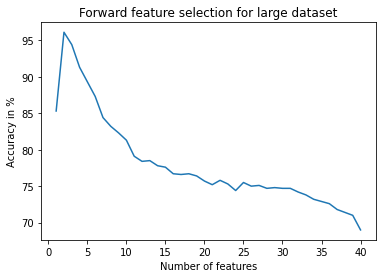

In [21]:
#plotting graph for forward selection
plt.plot(range(1,len(data[0])+1,1),best_accu)
plt.xlabel("Number of features")
plt.ylabel("Accuracy in %")
plt.title('Forward feature selection for large dataset')

In [22]:
best_accu=backward_feature_selection(data,labels)

At tree depth 0
With all the features i.e. ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]) accuracy is 69.0


At tree depth 1
Considering removing feature (1) 
And testing with features: ([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 69.5%
Considering removing feature (2) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 70.2%
Considering removing feature (3) 
And testing with features: ([1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 69.9%
Considering removing feature (4) 
And t

Considering removing feature (34) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 69.3%
Considering removing feature (35) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40]) the accuracy obtained is 69.3%
Considering removing feature (36) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 70.3%
Considering removing feature (37) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40]) the accuracy obtained is 68.5%
Considering removing feature

Considering removing feature (30) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 70.1%
Considering removing feature (31) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 69.5%
Considering removing feature (32) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 70.9%
Considering removing feature (33) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40]) the accuracy obtained is 70.2%
Considering removing feature (34) 
And testi

Considering removing feature (26) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 70.3%
Considering removing feature (27) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 69.6%
Considering removing feature (28) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 70.9%
Considering removing feature (29) 
And testing with features: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 71.4%
Considering removing feature (30) 
And testing with features

Considering removing feature (25) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 72.6%
Considering removing feature (26) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 70.7%
Considering removing feature (27) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 71.4%
Considering removing feature (28) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 70.9%
Considering removing feature (29) 
And testing with features: ([1, 3, 4,

Considering removing feature (25) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 71.9%
Considering removing feature (26) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 72.9%
Considering removing feature (27) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 72.6%
Considering removing feature (28) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 71.6%
Considering removing feature (29) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 9, 

Considering removing feature (27) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 72.5%
Considering removing feature (28) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 73.0%
Considering removing feature (29) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 72.2%
Considering removing feature (30) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 73.4%
Considering removing feature (31) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14,

Considering removing feature (30) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 73.2%
Considering removing feature (31) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 73.0%
Considering removing feature (32) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 74.5%
Considering removing feature (33) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40]) the accuracy obtained is 74.6%
Considering removing feature (34) 
And testing with features: ([1, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19,

Considering removing feature (35) 
And testing with features: ([1, 3, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40]) the accuracy obtained is 74.0%
Considering removing feature (37) 
And testing with features: ([1, 3, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40]) the accuracy obtained is 74.1%
Considering removing feature (38) 
And testing with features: ([1, 3, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40]) the accuracy obtained is 74.1%
Considering removing feature (39) 
And testing with features: ([1, 3, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40]) the accuracy obtained is 74.1%

Removing feature (3)
Considering the feature(s) ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28

Considering removing feature (4) 
And testing with features: ([1, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40]) the accuracy obtained is 73.9%
Considering removing feature (6) 
And testing with features: ([1, 4, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40]) the accuracy obtained is 74.0%
Considering removing feature (7) 
And testing with features: ([1, 4, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40]) the accuracy obtained is 75.2%
Considering removing feature (8) 
And testing with features: ([1, 4, 6, 7, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40]) the accuracy obtained is 74.9%
Considering removing feature (10) 
And testing with features: ([1, 4, 6, 7, 8, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

Considering removing feature (16) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.7%
Considering removing feature (17) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 75.4%
Considering removing feature (18) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 76.1%
Considering removing feature (19) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 75.0%
Considering removing feature (20) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 4

Considering removing feature (28) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.9%
Considering removing feature (29) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 73.8%
Considering removing feature (30) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.1%
Considering removing feature (31) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 73.6%
Considering removing feature (32) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 34, 37, 38, 39, 40]) the accuracy obt

Considering removing feature (7) 
And testing with features: ([1, 4, 6, 8, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.8%
Considering removing feature (8) 
And testing with features: ([1, 4, 6, 7, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 75.0%
Considering removing feature (10) 
And testing with features: ([1, 4, 6, 7, 8, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 75.2%
Considering removing feature (12) 
And testing with features: ([1, 4, 6, 7, 8, 10, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.4%
Considering removing feature (14) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.8%
Considering removing feat

Considering removing feature (31) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 29, 30, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.9%
Considering removing feature (32) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 29, 30, 31, 34, 37, 38, 39, 40]) the accuracy obtained is 76.8%
Considering removing feature (34) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 29, 30, 31, 32, 37, 38, 39, 40]) the accuracy obtained is 74.7%
Considering removing feature (37) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 29, 30, 31, 32, 34, 38, 39, 40]) the accuracy obtained is 76.2%
Considering removing feature (38) 
And testing with features: ([1, 4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 29, 30, 31, 32, 34, 37, 39, 40]) the accuracy obtained is 76.8%
Considering removing feature (39) 
And testin

Considering removing feature (25) 
And testing with features: ([4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 24, 26, 27, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.9%
Considering removing feature (26) 
And testing with features: ([4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 27, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.1%
Considering removing feature (27) 
And testing with features: ([4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 26, 29, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 76.4%
Considering removing feature (29) 
And testing with features: ([4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 26, 27, 30, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 74.0%
Considering removing feature (30) 
And testing with features: ([4, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 26, 27, 29, 31, 32, 34, 37, 38, 39, 40]) the accuracy obtained is 75.0%
Considering removing feature (31) 
And testing with features: ([4, 6, 7, 8, 10, 

Considering removing feature (24) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 25, 26, 27, 29, 30, 31, 34, 37, 38, 39, 40]) the accuracy obtained is 75.5%
Considering removing feature (25) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 24, 26, 27, 29, 30, 31, 34, 37, 38, 39, 40]) the accuracy obtained is 75.3%
Considering removing feature (26) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 27, 29, 30, 31, 34, 37, 38, 39, 40]) the accuracy obtained is 75.4%
Considering removing feature (27) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 26, 29, 30, 31, 34, 37, 38, 39, 40]) the accuracy obtained is 75.6%
Considering removing feature (29) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 26, 27, 30, 31, 34, 37, 38, 39, 40]) the accuracy obtained is 74.4%
Considering removing feature (30) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 24, 25, 26, 27

Considering removing feature (31) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 24, 26, 27, 29, 30, 34, 37, 38, 39, 40]) the accuracy obtained is 76.8%
Considering removing feature (34) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 24, 26, 27, 29, 30, 31, 37, 38, 39, 40]) the accuracy obtained is 75.0%
Considering removing feature (37) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 24, 26, 27, 29, 30, 31, 34, 38, 39, 40]) the accuracy obtained is 74.7%
Considering removing feature (38) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 24, 26, 27, 29, 30, 31, 34, 37, 39, 40]) the accuracy obtained is 75.3%
Considering removing feature (39) 
And testing with features: ([4, 6, 8, 10, 12, 14, 16, 17, 18, 24, 26, 27, 29, 30, 31, 34, 37, 38, 40]) the accuracy obtained is 75.4%

Removing feature (16)
Considering the feature(s) ([4, 6, 8, 10, 12, 14, 17, 18, 24, 26, 27, 29, 30, 31, 34, 37, 38, 39, 40])
Gave the best accuracy of 77.

Considering removing feature (24) 
And testing with features: ([6, 8, 10, 12, 14, 17, 18, 26, 27, 29, 30, 34, 37, 38, 39, 40]) the accuracy obtained is 75.2%
Considering removing feature (26) 
And testing with features: ([6, 8, 10, 12, 14, 17, 18, 24, 27, 29, 30, 34, 37, 38, 39, 40]) the accuracy obtained is 74.2%
Considering removing feature (27) 
And testing with features: ([6, 8, 10, 12, 14, 17, 18, 24, 26, 29, 30, 34, 37, 38, 39, 40]) the accuracy obtained is 75.6%
Considering removing feature (29) 
And testing with features: ([6, 8, 10, 12, 14, 17, 18, 24, 26, 27, 30, 34, 37, 38, 39, 40]) the accuracy obtained is 73.6%
Considering removing feature (30) 
And testing with features: ([6, 8, 10, 12, 14, 17, 18, 24, 26, 27, 29, 34, 37, 38, 39, 40]) the accuracy obtained is 74.2%
Considering removing feature (34) 
And testing with features: ([6, 8, 10, 12, 14, 17, 18, 24, 26, 27, 29, 30, 37, 38, 39, 40]) the accuracy obtained is 73.5%
Considering removing feature (37) 
And testing with 

Considering removing feature (39) 
And testing with features: ([6, 10, 12, 14, 17, 18, 26, 29, 30, 34, 37, 38, 40]) the accuracy obtained is 73.4%

Removing feature (37)
Considering the feature(s) ([6, 10, 12, 14, 17, 18, 26, 29, 30, 34, 38, 39, 40])
Gave the best accuracy of 75.9%

Model did not improve on this level continuing search


At tree depth 28
Considering removing feature (6) 
And testing with features: ([10, 12, 14, 17, 18, 26, 29, 30, 34, 38, 39, 40]) the accuracy obtained is 74.3%
Considering removing feature (10) 
And testing with features: ([6, 12, 14, 17, 18, 26, 29, 30, 34, 38, 39, 40]) the accuracy obtained is 74.4%
Considering removing feature (12) 
And testing with features: ([6, 10, 14, 17, 18, 26, 29, 30, 34, 38, 39, 40]) the accuracy obtained is 74.4%
Considering removing feature (14) 
And testing with features: ([6, 10, 12, 17, 18, 26, 29, 30, 34, 38, 39, 40]) the accuracy obtained is 75.1%
Considering removing feature (17) 
And testing with features: ([6, 10, 

Considering removing feature (10) 
And testing with features: ([6, 12, 18, 29, 30, 38, 40]) the accuracy obtained is 77.1%
Considering removing feature (12) 
And testing with features: ([6, 10, 18, 29, 30, 38, 40]) the accuracy obtained is 76.1%
Considering removing feature (18) 
And testing with features: ([6, 10, 12, 29, 30, 38, 40]) the accuracy obtained is 71.9%
Considering removing feature (29) 
And testing with features: ([6, 10, 12, 18, 30, 38, 40]) the accuracy obtained is 74.7%
Considering removing feature (30) 
And testing with features: ([6, 10, 12, 18, 29, 38, 40]) the accuracy obtained is 78.5%
Considering removing feature (38) 
And testing with features: ([6, 10, 12, 18, 29, 30, 40]) the accuracy obtained is 75.1%

Removing feature (30)
Considering the feature(s) ([6, 10, 12, 18, 29, 38, 40])
Gave the best accuracy of 78.5%


At tree depth 34
Considering removing feature (6) 
And testing with features: ([10, 12, 18, 29, 38, 40]) the accuracy obtained is 75.9%
Considering 

Text(0.5, 1.0, 'Backward elimination for large dataset')

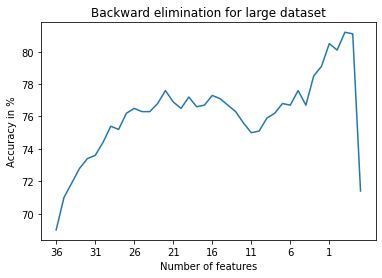

In [23]:
#plotting the graph for backward elimination
plt.plot(range(1,len(data[0])+1),best_accu)
plt.xlabel("Number of features")
x = np.arange(1, len(data[0])+1, 5)
plt.xticks(x,x[::-1])
plt.ylabel("Accuracy in %")
plt.title('Backward elimination for large dataset')

In [32]:
def forward_plotter(bestaccu,data):
    #plotting graph for forward selection
    plt.plot(range(1,len(data[0])+1,1),bestaccu)
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy in %")
    plt.title('Forward feature selection for large dataset')

In [33]:
def backward_plotter(bestaccu,data):
    #plotting the graph for backward elimination
    plt.plot(range(1,len(data[0])+1),bestaccu)
    plt.xlabel("Number of features")
    x = np.arange(1, len(data[0])+1, 5)
    plt.xticks(x,x[::-1])
    plt.ylabel("Accuracy in %")
    plt.title('Backward elimination for large dataset')

Feature Selection algortihm

Enter the name of the file to test: small_37.txt

Type the number of the algortihm you want to run.
1. Forward Selection
2. Backward Elimination
1

This dataset has 10 features and 300 instances.


At tree depth 1
Considering adding feature(s) (0) 
Gave an accuracy of 65.33%
Considering adding feature(s) (1) 
Gave an accuracy of 72.0%
Considering adding feature(s) (2) 
Gave an accuracy of 68.67%
Considering adding feature(s) (3) 
Gave an accuracy of 67.0%
Considering adding feature(s) (4) 
Gave an accuracy of 65.67%
Considering adding feature(s) (5) 
Gave an accuracy of 67.33%
Considering adding feature(s) (6) 
Gave an accuracy of 65.67%
Considering adding feature(s) (7) 
Gave an accuracy of 67.67%
Considering adding feature(s) (8) 
Gave an accuracy of 86.0%
Considering adding feature(s) (9) 
Gave an accuracy of 62.67%

Adding feature (8)
Considering the feature(s): ([8])
Gave best accuracy of 86.0%


At tree depth 2
Considering adding feature (0)
And testi

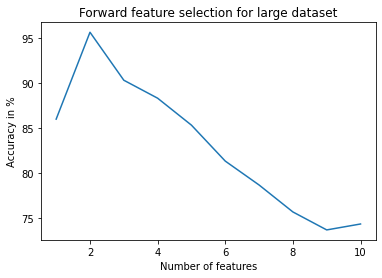

In [40]:
#wrapper function to call the differnt methods
def wrapper():
    print("Feature Selection algortihm")
    filename=input("\nEnter the name of the file to test: ")
    ch=int(input("\nType the number of the algortihm you want to run.\n1. Forward Selection\n2. Backward Elimination\n"))
    data,labels=load_data(filename)
    print("\nThis dataset has {0} features and {1} instances.".format(data.shape[1],data.shape[0]))
    if(ch==1):
        #start=time.time()
        bestaccu=forward_feature_selection(data,labels)
        #print("\n\n\ntime taken",time.time()-start)
        forward_plotter(bestaccu,data)
    else:
        #start=time.time()
        bestaccu=backward_feature_selection(data,labels)
        #print("\n\n\ntime taken", time.time()-start)
        backward_plotter(bestaccu,data)
wrapper()